In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# 加载模型和 tokenizer
def load_model_and_tokenizer(model_name, device="cuda"):
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # torch_dtype=torch.float16,
        device_map="auto",
        # attn_implementation="eager",
    )
    return model, tokenizer

In [5]:
# model_name = "mistralai/Mistral-7B-Instruct-v0.1"
model_name = "Qwen/Qwen2-0.5B-Instruct"
device = "cuda" if torch.cuda.is_available() else "mps"

# 加载模型和 tokenizer
model, tokenizer = load_model_and_tokenizer(model_name, device)

model.config.sliding_window = 1024

Loading model: Qwen/Qwen2-0.5B-Instruct


In [71]:
# 加载和分词输入
dataset = load_dataset("emozilla/pg19", split="test", trust_remote_code=True)
text = dataset[0]["text"]  # 仅取前 16384 个字符
input_ids = tokenizer(text, return_tensors="pt", max_length=129, truncation=True).input_ids

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [73]:
input_ids = input_ids[:, 1:]

In [74]:
print(input_ids)

tensor([[   13, 12878,  1094, 12210,  1406,    36,  9345, 10030,   553, 15115,
           482, 15681,   337, 52369,   323,   279,  5787, 51586,  8105,   198,
            35, 25146, 36991,  6154,  7909,  1022,   787, 16413, 27629, 42653,
          3008,   393,  1271,    36,   640, 82831,  1964,  3928,    13, 12878,
          1094,   271,    32, 11101,   315, 28361, 33891,   369,   323, 29014,
           304,   279, 13385,   198,    47, 55398,  8445,   382,  1359, 16654,
         16012, 11418,  5881, 34583, 20594,  4592, 57567, 12152,  2941,    38,
         14017,  3008,   393,  1271,    36,   640, 82831,   382,    32,   425,
          4305, 14884,   451,  3915,  3495,  3008, 28167,    50,  3567, 58619,
         63022,  1479,  4769,  3168, 90296,  8932,   198,    35, 22063,  3008,
          3928,    13, 12878,  1094,    11,   422, 73049, 16165,  4592,  2537,
          4321,  4192,  2679,  7801,   386,    13,  7684, 92923,  1410, 64778,
           279,  9393,   323,  1281,   264,  7216,  

In [75]:
# 提取注意力分数
# 模型前向
with torch.no_grad():
    output = model(input_ids.to(device), output_attentions=True, output_hidden_states=True)

In [7]:
print(output.keys())

odict_keys(['logits', 'past_key_values', 'attentions'])


In [8]:
print(len(output["attentions"]))

24


In [51]:
output["attentions"][0].shape

torch.Size([1, 14, 128, 128])

In [76]:
def visualize_attention_scores(
    attention_scores,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    可视化 Transformer 注意力分数矩阵。
    """
    plt.figure(figsize=(10, 8))
    attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )

    # 绘制矩阵
    im = plt.imshow(attention_matrix, cmap=cmap, aspect="auto")
    plt.colorbar(im, label="Normalized Attention Score")
    plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")

    # 可选：添加数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                plt.text(j, i, f"{attention_matrix[i, j]:.2f}", ha="center", va="center", fontsize=6)

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()


# # 可视化某一层的注意力分数
# def visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file=None):
#     plt.figure(figsize=(10, 8))
#     attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
#     plt.imshow(attention_matrix, cmap="viridis", aspect="auto")
#     plt.colorbar(label="Attention Score")
#     plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
#     plt.xlabel("Key Position")
#     plt.ylabel("Query Position")
#     if output_file:
#         plt.savefig(output_file)
#     plt.show()


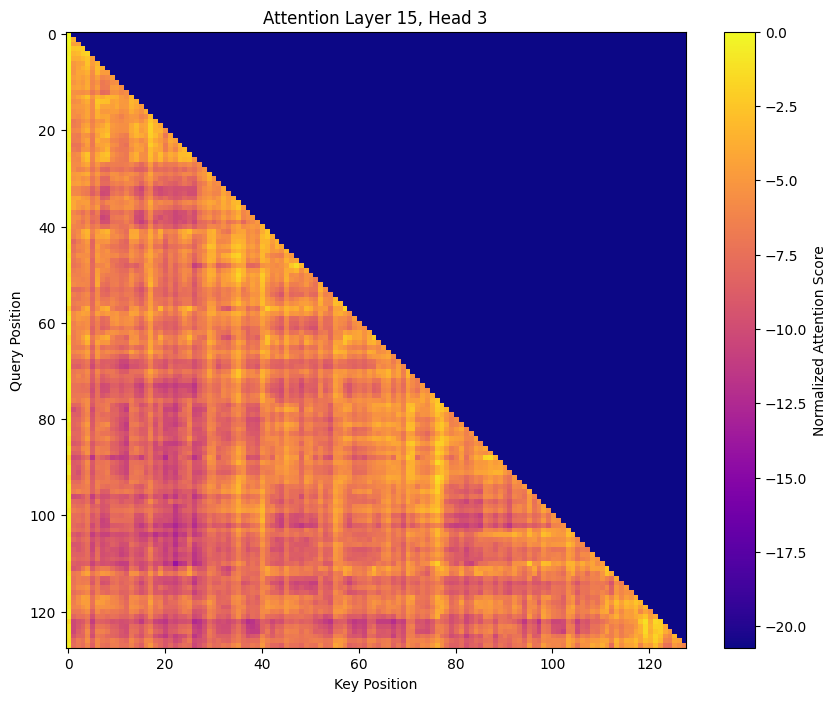

In [77]:

attention_scores = output["attentions"]

# 保存或可视化
layer_idx = 14  # 可视化第几层
head_idx = 2   # 可视化第几个注意力头
seq_len = 8192  # 只显示前 1024 长度的分数（避免图太大）
visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file="attention_layer_1_head_1.png")

# # 保存完整注意力分数到文件
# torch.save(attention_scores, "attention_scores.pt")
# print("Attention scores saved to 'attention_scores.pt'")

In [19]:
print(output["attentions"][0].shape)

torch.Size([1, 32, 2110, 2110])


In [66]:
# 计算hidden_states特定token的方差

layer_idx = 14  # 可视化第几层
head_idx = 2   # 可视化第几个注意力头

# 提取特定 token 的隐藏状态
hidden_states = output["hidden_states"][layer_idx]

# 计算每个token各自的方差 保存为一个list
for i in range(hidden_states.shape[1]):
    variance = torch.var(hidden_states[:, i, :])
    print(variance)

tensor(1996.0865, device='mps:0')
tensor(0.3426, device='mps:0')
tensor(0.3417, device='mps:0')
tensor(0.4636, device='mps:0')
tensor(0.3606, device='mps:0')
tensor(0.3096, device='mps:0')
tensor(0.2825, device='mps:0')
tensor(0.4539, device='mps:0')
tensor(0.4328, device='mps:0')
tensor(0.3813, device='mps:0')
tensor(0.3680, device='mps:0')
tensor(0.3908, device='mps:0')
tensor(0.3371, device='mps:0')
tensor(0.3516, device='mps:0')
tensor(0.4447, device='mps:0')
tensor(0.3232, device='mps:0')
tensor(0.3575, device='mps:0')
tensor(0.4055, device='mps:0')
tensor(0.5079, device='mps:0')
tensor(0.3903, device='mps:0')
tensor(0.3173, device='mps:0')
tensor(0.2741, device='mps:0')
tensor(0.3896, device='mps:0')
tensor(0.3542, device='mps:0')
tensor(0.4063, device='mps:0')
tensor(0.4302, device='mps:0')
tensor(0.3172, device='mps:0')
tensor(0.3094, device='mps:0')
tensor(0.3483, device='mps:0')
tensor(0.4229, device='mps:0')
tensor(0.4767, device='mps:0')
tensor(0.4106, device='mps:0')
tenso

In [50]:
print(output["hidden_states"][layer_idx][0, :, (head_idx-1)*:head_idx].shape)

torch.Size([128, 896])
